In [12]:
from PIL import Image, ImageDraw, ImageFont

# Define the image dimensions
width, height = 5000, 5000

# Create a new image with transparent background
img = Image.new('RGBA', (width, height))

# Create a draw object
draw = ImageDraw.Draw(img)

# Define the font and size
font = ImageFont.truetype('arial.ttf', size=8000)

# Define the letter
letter = 'A'

# Get the size of the letter
text_size = draw.textsize(letter, font=font)

# Calculate the width and height to center the text
x = (width - text_size[0])/2
y = (height - text_size[1])/2

# Draw the letter with a color of black and full opacity
draw.text((x, y), letter, fill='black', font=font)

# Save the image
img.save('letter_A.png')


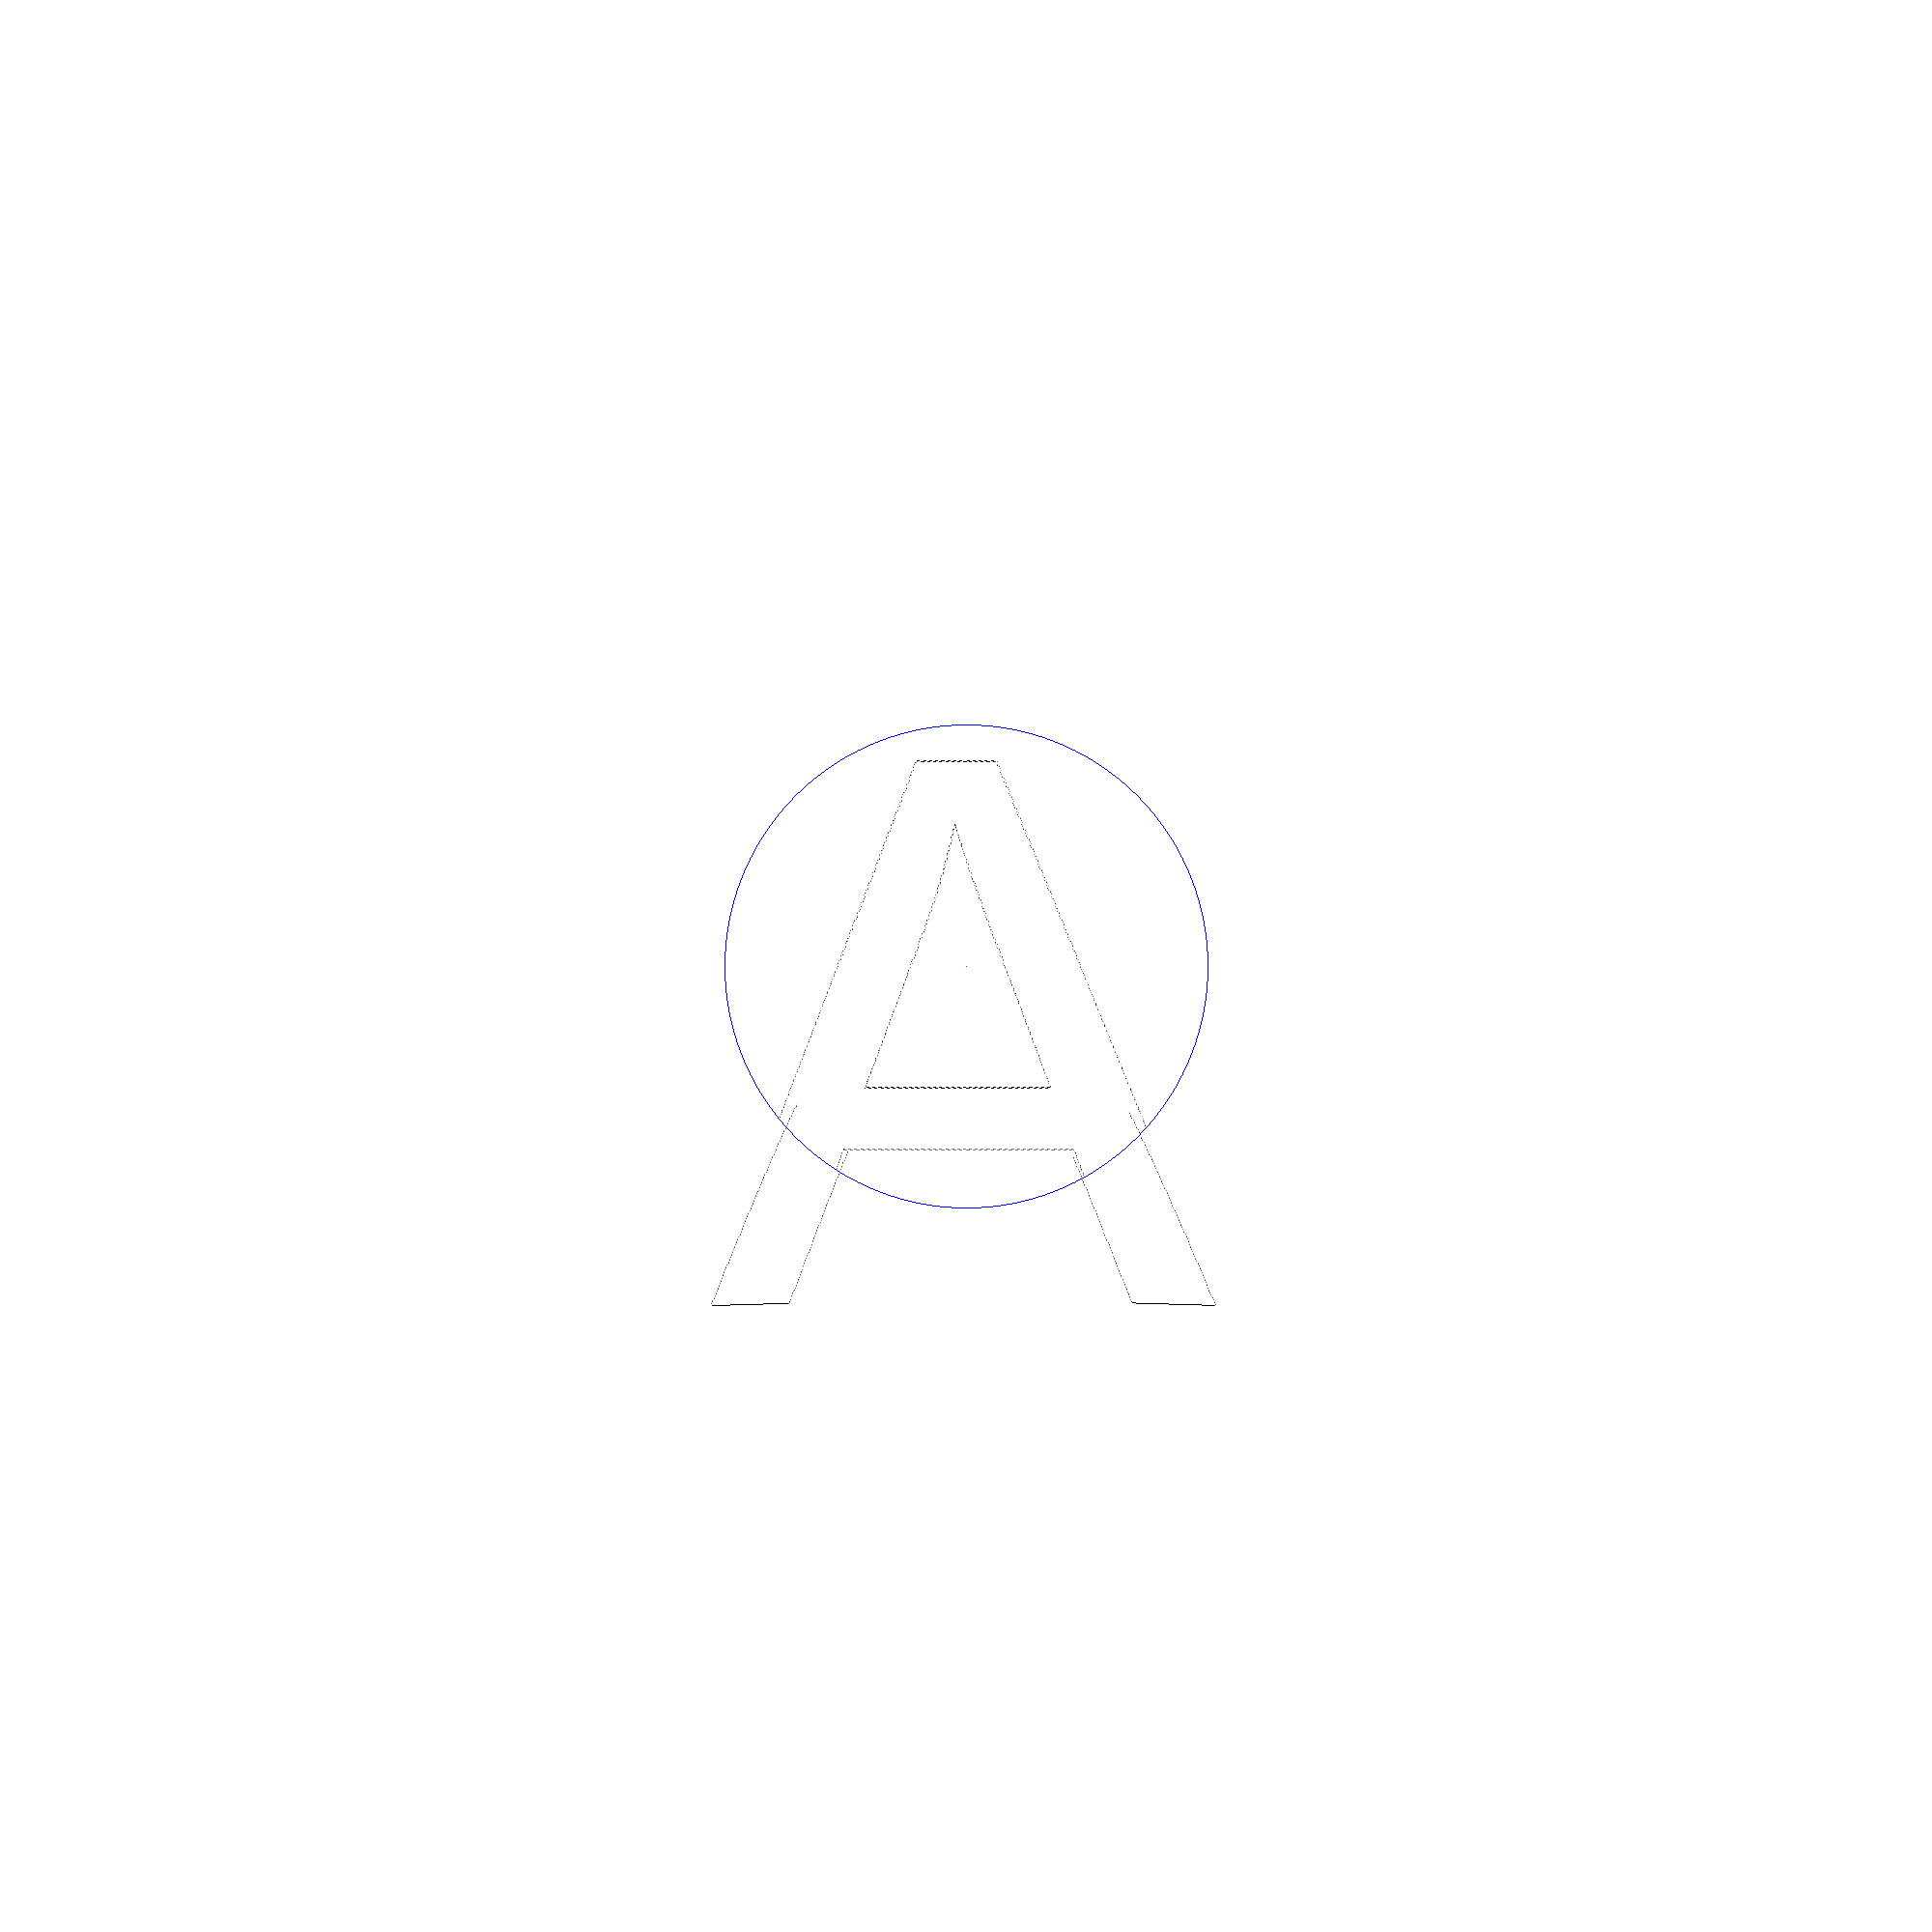

In [30]:
from PIL import Image, ImageDraw
import numpy as np
import math

def distortion_fn(X, Y, R_sun):
    R = np.hypot(X, Y)  # Euclidean distance from the center
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
    M = 1.989e30  # mass of the sun in kg
    c = 299792458  # speed of light in m/s
    inside_sun = R <= R_sun  # mask for regions inside the sun
    outside_sun = R > R_sun  # mask for regions outside the sun
    distortion = np.where(outside_sun, 4 * G * M / (c**2 * R+1e-8), np.sin(X) * np.sin(Y))  # Different distortions inside and outside the sun
    return distortion 

def lens_distortion(img, distortion_fn, R_sun):
    w, h = img.size
    img_np = np.array(img)

    x = np.arange(w) - w/2  # x-coordinates
    y = h/2 - np.arange(h)  # y-coordinates

    X, Y = np.meshgrid(x, y)  # matrices of coordinates
    Theta = np.sqrt(X**2 + Y**2)  # matrix of radiuses (in pixels)

    # Apply the distortion
    D = distortion_fn(X,Y, R_sun)

    # Calculate the distorted coordinates
    Xd = X - D*X/(Theta + 1e-8)  # small constant added to avoid division by zero
    Yd = Y - D*Y/(Theta + 1e-8) 
    Xd = np.clip(Xd + w/2, 0, w-1).astype(int)
    Yd = np.clip(h/2 - Yd, 0, h-1).astype(int)

    # Create the distorted image preserving alpha channel
    distorted_img_np = np.zeros_like(img_np)
    
    # Mask for pixels where alpha is not zero and the pixel is black
    mask = np.logical_and(img_np[..., 3] > 0, np.all(img_np[..., :3] == 0, axis=-1))
    
    # Apply the distortion only to the black pixels
    distorted_img_np[Yd[mask], Xd[mask]] = img_np[mask]

    return Image.fromarray(distorted_img_np)

# Load the image
img = Image.open('outlined_letter_A.png')  # Replace this with your actual filename

# Apply the distortion
R_sun = img.size[0] / 8  # adjust this value according to your image and how you define the sun's radius in pixels
distorted_img = lens_distortion(img, distortion_fn, R_sun)

# Draw a red mark at the center of the image and a blue circle with the defined radius of the sun
draw = ImageDraw.Draw(distorted_img)
draw.point((distorted_img.size[0] // 2, distorted_img.size[1] // 2), fill='red')  # Draw the center point
draw.ellipse([(distorted_img.size[0] // 2 - R_sun, distorted_img.size[1] // 2 - R_sun), 
              (distorted_img.size[0] // 2 + R_sun, distorted_img.size[1] // 2 + R_sun)], 
             outline='blue')  # Draw the circlee

# Save the image
distorted_img.save('distorted_outlined_a.png')

# Display the image
display(distorted_img)


In [16]:
print(img.size[0])

5000


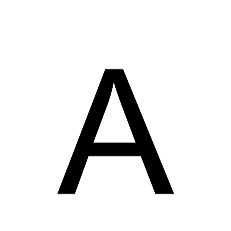

In [56]:
distorte_img = Image.open('letter_A.png')

# Display the image
plt.imshow(distorte_img)
plt.axis('off')  # remove the axis
plt.show()